In [1]:
# !pip install pandas
# !pip install seaborn
# !pip install sklearn
# !pip install pyenchant
# !apt-get install libenchant1c2a

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing import sequence
import os 
# os.chdir('/content/drive/MyDrive/NeuralResearch/wine-net/')

# os.chdir('/content/drive/MyDrive/MSCA_31009/Final_Project/')

def remove_punctuation(s):
  punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

  # Removing punctuations in string
  # Using loop + punctuation string
  for ele in s:
      if ele in punc:
          s = s.replace(ele, "")
  return s

def clean_description(review, swap):
  terms = review.split()
  for x in terms:
    try: x = swap[('t_' + str(x))]
    except KeyError: x = ''
  return ' '.join(terms)


In [4]:
wines = pd.read_csv('winemag-data-130k-v2.csv')
wines = wines.drop(columns = ['Unnamed: 0'])

wines2 = pd.read_csv('winemag-data_first150k.csv')
wines2.head()

# Intersect and append two review tables
columns = [value for value in wines.columns if value in wines2.columns] # intersection(wines.columns, wines2.columns)
wines = wines[columns]
wines2 = wines2[columns]
wines = pd.concat([wines, wines2]).drop(columns = ['designation', 'winery'])

# wines = wines.sample(n=20000)
# Actual wines
var = list(wines.variety.value_counts()[wines.variety.value_counts() > 10000].index)
wines = wines[wines.variety.isin(var)]

# Imputation steps
median_price = wines.price.median()
median_points = wines.points.median()

# Impute variables
wines.price = wines.price.fillna(median_price)
wines.points = wines.points.fillna(median_points)
wines = wines.fillna('')
wines.price = wines.price.astype(int)
wines.description = wines.description.apply(lambda x: remove_punctuation(x.lower()))

Y = wines.variety
output_shape = Y.nunique()
Y0_price = wines.price
Y1_points = wines.points.apply(lambda x: 1 if x > 87 else 0)


wines.head()

,country,description,points,price,province,region_1,region_2,variety
3,US,pineapple rind lemon pith and orange blossom s...,87,13,Michigan,Lake Michigan Shore,,Riesling
4,US,much like the regular bottling from 2012 this ...,87,65,Oregon,Willamette Valley,Willamette Valley,Pinot Noir
10,US,soft supple plum envelopes an oaky structure i...,87,19,California,Napa Valley,Napa,Cabernet Sauvignon
12,US,slightly reduced this wine offers a chalky tan...,87,34,California,Alexander Valley,Sonoma,Cabernet Sauvignon
14,US,building on 150 years and six generations of w...,87,12,California,Central Coast,Central Coast,Chardonnay


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


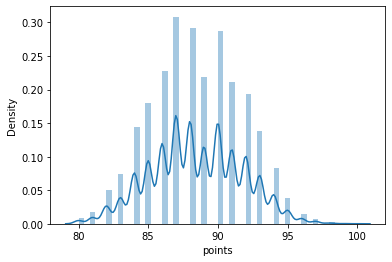

In [5]:
sns.distplot(wines.points)
wines = wines.drop(columns=['variety', 'price', 'points', 'region_1', 'region_2'])

In [6]:
Y.value_counts()

Pinot Noir                  27563
Chardonnay                  26235
Cabernet Sauvignon          22272
Red Blend                   19008
Bordeaux-style Red Blend    14262
Sauvignon Blanc             11287
Riesling                    10713
Name: variety, dtype: int64

In [7]:
# vectorizing the rest of the data in the table.
wines.head()

,country,description,province
3,US,pineapple rind lemon pith and orange blossom s...,Michigan
4,US,much like the regular bottling from 2012 this ...,Oregon
10,US,soft supple plum envelopes an oaky structure i...,California
12,US,slightly reduced this wine offers a chalky tan...,California
14,US,building on 150 years and six generations of w...,California


In [8]:
from keras.preprocessing.text import Tokenizer
X = wines.description.to_numpy()
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X)
num_words = len(tokenizer.word_index)+1
X = tokenizer.texts_to_sequences(X)
max_log_length = 1024
X_processed = sequence.pad_sequences(X, maxlen=max_log_length)
X_processed

array([[   0,    0,    0, ...,  517, 2384,   18],
       [   0,    0,    0, ...,  862, 3749, 2886],
       [   0,    0,    0, ...,    1, 1194, 5234],
       ...,
       [   0,    0,    0, ...,   49,  421,    8],
       [   0,    0,    0, ...,   29, 2199,   84],
       [   0,    0,    0, ...,  629,    2,  221]], dtype=int32)

In [9]:
from sklearn.preprocessing import LabelEncoder
# encode class values as integers
print(Y1_points.nunique())
encoder = LabelEncoder()
encoder.fit(Y)
Y_processed = encoder.transform(Y)
Y1 = Y1_points.to_numpy()
Y1
Y = Y.to_numpy()
Y

2


array(['Riesling', 'Pinot Noir', 'Cabernet Sauvignon', ..., 'Pinot Noir',
       'Pinot Noir', 'Pinot Noir'], dtype=object)

In [10]:
# words_df = words_df.reset_index()
# wines = wines.reset_index()
# wines = pd.concat([wines, words_df], axis=1)
# wines.shape
# wines = wines.drop(columns = ['index'])

## Variety Classifier

In [11]:
from keras.models import Sequential
from keras import layers
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

from keras.callbacks import TensorBoard
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from collections import OrderedDict

X_train, X_test, y_train, y_test = train_test_split(X_processed, Y1_points, test_size=0.25, random_state=0)

input_dim = X_train.shape[1]

## RNN Build

In [12]:
# from tensorflow.keras.layers import Dense, LSTM, Embedding,Dropout,SpatialDropout1D,Conv1D,MaxPooling1D,GRU,BatchNormalization
# from tensorflow.keras.layers import Input,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate,LeakyReLU
# from tensorflow.keras import regularizers
# from tensorflow.keras import backend as K

# model = Sequential()
# model.add(Embedding(input_dim=X_train.shape[0], output_dim=X_train.shape[1], weights=[X_train], input_length=max_log_length, trainable=False))
# model.add(SpatialDropout1D(0.5))
# model.add(Conv1D(filters=32, kernel_size=10 , kernel_regularizer=regularizers.l2(0.00001), padding='same'))
# model.add(LeakyReLU(alpha=0.2))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Bidirectional(LSTM(units=64,dropout=0.5, recurrent_dropout=0.5,return_sequences=True)))
# model.add(SpatialDropout1D(0.5))
# model.add(Conv1D(filters=32, kernel_size=10 ,kernel_regularizer=regularizers.l2(0.00001), padding='same'))
# model.add(LeakyReLU(alpha=0.2))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Bidirectional(LSTM(lstm_units,dropout=0.5, recurrent_dropout=0.5,return_sequences=True)))
# model.add(SpatialDropout1D(0.5))
# model.add(Conv1D(filters=32, kernel_size=10 ,kernel_regularizer=regularizers.l2(0.00001), padding='same'))
# model.add(LeakyReLU(alpha=0.2))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Bidirectional(LSTM(lstm_units,dropout=0.5, recurrent_dropout=0.5)))
# model.add(Dense(4,activation='softmax'))

## CNN Build

In [13]:
# from tensorflow.keras.layers import Dense, LSTM, Embedding,Dropout,SpatialDropout1D,Conv1D,MaxPooling1D,GRU,BatchNormalization
# from tensorflow.keras.layers import Input,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate,LeakyReLU
# from tensorflow.keras import regularizers
# from tensorflow.keras import backend as K

# X_train, X_test, y_train, y_test = train_test_split(X_processed, Y1_points, test_size=0.25, random_state=0)

# input_dim = X_train.shape[1]

# model = Sequential()
# model.add(Embedding(input_dim=X_train.shape[0], output_dim=X_train.shape[1], weights=[X_train], input_length=max_log_length, trainable=False))


# model.add(SpatialDropout1D(0.5))
# model.add(Conv1D(filters=128, kernel_size=3 , kernel_regularizer=regularizers.l2(0.00001), padding='same'))
# model.add(LeakyReLU(alpha=0.2))
# model.add(MaxPooling1D(pool_size=2))

# model.add(SpatialDropout1D(0.5))
# model.add(Conv1D(filters=128, kernel_size=3 ,kernel_regularizer=regularizers.l2(0.00001), padding='same'))
# model.add(LeakyReLU(alpha=0.2))
# model.add(MaxPooling1D(pool_size=2))

# model.add(SpatialDropout1D(0.5))
# model.add(Conv1D(filters=128, kernel_size=3 ,kernel_regularizer=regularizers.l2(0.00001), padding='same'))
# model.add(LeakyReLU(alpha=0.2))
# model.add(MaxPooling1D(pool_size=2))

# model.add(SpatialDropout1D(0.5))
# model.add(Conv1D(filters=128, kernel_size=3 ,kernel_regularizer=regularizers.l2(0.00001), padding='same'))
# model.add(LeakyReLU(alpha=0.2))
# model.add(MaxPooling1D(pool_size=2))

# model.add(SpatialDropout1D(0.5))
# model.add(Conv1D(filters=128, kernel_size=3 ,kernel_regularizer=regularizers.l2(0.00001), padding='same'))
# model.add(LeakyReLU(alpha=0.2))
# model.add(MaxPooling1D(pool_size=2))

# model.add(SpatialDropout1D(0.5))
# model.add(Conv1D(filters=128, kernel_size=3 ,kernel_regularizer=regularizers.l2(0.00001), padding='same'))
# model.add(LeakyReLU(alpha=0.2))
# model.add(MaxPooling1D(pool_size=2))

# model.add(tf.keras.layers.Flatten())
# model.add(Dense(1, activation='softmax'))

# model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
# model.summary()


## CNN Build II

In [18]:
from tensorflow.keras.layers import Dense, LSTM, Embedding,Dropout,SpatialDropout1D,Conv1D,MaxPooling1D,GRU,BatchNormalization
from tensorflow.keras.layers import Input,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate,LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

X_train, X_test, y_train, y_test = train_test_split(X_processed, Y_processed, test_size=0.25, random_state=0)

input_dim = X_train.shape[1]

model = Sequential()
model.add(Embedding(input_dim=X_train.shape[0], output_dim=X_train.shape[1], weights=[X_train], input_length=max_log_length, trainable=False))

model.add(SpatialDropout1D(0.5))
model.add(Conv1D(filters=32, kernel_size=3 , kernel_regularizer=regularizers.l2(0.00001), padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling1D(pool_size=2))

model.add(SpatialDropout1D(0.5))
model.add(Conv1D(filters=32, kernel_size=3 ,kernel_regularizer=regularizers.l2(0.00001), padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling1D(pool_size=2))

model.add(SpatialDropout1D(0.5))
model.add(Conv1D(filters=32, kernel_size=3 ,kernel_regularizer=regularizers.l2(0.00001), padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling1D(pool_size=2))

model.add(SpatialDropout1D(0.5))
model.add(Conv1D(filters=32, kernel_size=3 ,kernel_regularizer=regularizers.l2(0.00001), padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling1D(pool_size=2))

model.add(SpatialDropout1D(0.5))
model.add(Conv1D(filters=32, kernel_size=3 ,kernel_regularizer=regularizers.l2(0.00001), padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling1D(pool_size=2))

model.add(SpatialDropout1D(0.5))
model.add(Conv1D(filters=32, kernel_size=3 ,kernel_regularizer=regularizers.l2(0.00001), padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Flatten())
model.add(Dense(output_shape, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1024, 1024)        100869120 
                                                                 
 spatial_dropout1d_12 (Spati  (None, 1024, 1024)       0         
 alDropout1D)                                                    
                                                                 
 conv1d_12 (Conv1D)          (None, 1024, 32)          98336     
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 1024, 32)          0         
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 512, 32)          0         
 g1D)                                                            
                                                                 
 spatial_dropout1d_13 (Spati  (None, 512, 32)         

In [ ]:
model.fit(x=X_train, y = y_train, batch_size = 512, epochs = 1000)

Epoch 1/1000
6157/6157 [==============================] - 37s 6ms/step - loss: 0.0018 - accuracy: 0.1694
Epoch 2/1000
6157/6157 [==============================] - 36s 6ms/step - loss: 0.0018 - accuracy: 0.1696
Epoch 3/1000
6157/6157 [==============================] - 36s 6ms/step - loss: 0.0014 - accuracy: 0.1696
Epoch 4/1000
2310/6157 [==========>...................] - ETA: 22s - loss: 0.0011 - accuracy: 0.1697

In [ ]:
model.evaluate(X_test, y_test, batch_size=128)